# KKProject_7_TestingAndEvaluation

In this notebook I'll be optimising the iForest algorithm and evaluating it.


## Summary from last notebook

- the new dats generated by Rohan works well with the iForest algorithm
- We need to optimise the algorithm by using test data

## The next steps would be

- after an optimised iForest algorithm is found, we need to translate the result into thresholds that can be put into the Arduino
- I expect this to be a reciprocal curve, so to simplify the curve fit we'd take a reciprocal of the data, fit the curve with the correct polynomial, then re-reciprocal it.

## Libraries needed

In [2]:
# file management
import os
import pickle

# mathematical
import numpy as np
from scipy.spatial.distance import cdist 

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# modelling

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

## Functions

In [3]:
def directory_to_df(path,filetype = '.csv',ignore_index = True):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    filetype: a string of the file extension (must include .)
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    for filename in os.listdir(path):
        if filetype in filename:
            curr_df = pd.read_csv(path+filename)
            frames.append(curr_df)
            filenames.append(filename.replace(filetype,''))
            for i in range(curr_df.shape[0]):
                file_column.append(test_index)
            test_index+=1
    
    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames

## New data

In [4]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/Rohan/' #note, this will yield different results now.

df,files = directory_to_df(path,ignore_index = False)

columns = df.columns.values.tolist()
columns.remove('date')
df.drop('gyrZ',inplace = True, axis = 1)

df.columns = columns
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
df['index'] = [i for i in range(df.shape[0])]
df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal,index
2020-09-09 16:27:07,0.08,0.01,0.11,-13.49,5.99,-21.58,1,0.136382,26.144915,0
2020-09-09 16:27:08,0.05,-0.03,-0.12,22.86,23.19,-1.88,1,0.133417,32.617328,1
2020-09-09 16:27:09,0.00,-0.01,0.00,4.29,-5.49,7.91,1,0.010000,10.540982,2
2020-09-09 16:27:09,-0.03,0.06,-0.14,-16.51,-0.30,-1.01,1,0.155242,16.543585,3
2020-09-09 16:27:10,-0.01,0.00,0.01,2.25,-21.86,11.49,1,0.014142,24.798028,4


## Test Data

In [5]:
path = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/TestData/'

df_test, files = directory_to_df(path, ignore_index = False)
columns = df_test.columns.values.tolist()
columns.remove('date')
df_test.drop('gyrZ',inplace = True, axis = 1)
df_test.columns = columns
df_test['accTotal'] = np.sqrt(np.power(df_test[['accX','accY','accZ']],2).sum(axis = 1))
df_test['gyrTotal'] = np.sqrt(np.power(df_test[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
print(files)
df_test.head()

['adjusting-seating-position', 'falling', 'crossing-arms', 'walking', 'crossing-legs', 'fetching-remote', 'sitting-down', 'lifting-leg', 'lying-down']


,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
2020-09-11 18:38:55,0.03,0.03,0.00,2.64,1.00,0.26,1,0.042426,2.834996
2020-09-11 18:38:56,0.01,0.01,0.00,0.85,1.00,0.26,1,0.014142,1.337946
2020-09-11 18:38:57,0.01,0.02,0.03,5.10,9.25,7.77,1,0.037417,13.112795
2020-09-11 18:38:58,0.05,0.02,0.03,5.10,13.47,14.31,1,0.061644,20.303374
2020-09-11 18:38:58,0.05,0.07,0.09,15.22,13.47,14.31,1,0.124499,24.856898


## Data preparation for model

In [6]:
significance = [1,-1,1,-1,1,-1,-1,-1,1] # -1 == sig, 1 == non sig
scaler = MinMaxScaler()
X_test = []
Y_test = []
for filetype in df_test.files.unique():
    X_test.append(scaler.fit_transform(np.asarray(df_test[['accTotal','gyrTotal']][df_test.files == filetype])))
    Y_test.append(np.asarray([significance[filetype -1] for i in range(X_test[filetype-1].shape[0])]))
    
X_train = scaler.fit_transform(np.asarray(df[['accTotal','gyrTotal']]))

## Evaluation

In [7]:
def findBestModel(X_train, X_test, Y_test, model='iForest'):
    """ Function to find the best parameters to use for a given model 
    components: 
    X_train: numpy array of the input data
    X_test: list containing numpy arrays of different test data
    Y_test: list containing numpy array of different test outcomes (note that this is configured differently 
    for different algorithms,for iForest, each column must have -1 or 1. -1 --> the anomaly, if 1 --> not an anomaly)
    model: string to determine model type
    """
    if model == 'iForest':
        total_score = 0;
        parameters = [0,0,0,0]
        for max_features in range(1,X_train.shape[1]+1):
            for contamination in range(1,101):
                iForest = IsolationForest(n_estimators = 100, max_features = max_features,\
                                         contamination = contamination/1000, random_state = 0).fit(X_train)
                
                scores = []
                for x_test,y_test in zip(X_test,Y_test):
                    y_hat = iForest.predict(x_test)
                    score = evaluate(y_test,y_hat) # returns similarity percentage
                    scores.append(score)
                
                if sum(scores) > total_score:
                    total_score = sum(scores)
                    parameters[0] = max_features
                    parameters[1] = contamination/1000
                    parameters[2] = total_score
                    parameters[3] = scores
                    print(parameters, contamination)
    
    return parameters

def evaluate(y_test, y_hat):
    """ function to evaluate the score of a predicted array and a 'ground truth' array
    components:
    y_test:
    y_hat:
    """
    score = np.sum(y_test==y_hat)/len(y_test)
    return score

"""
def plot():
    #put this plotting into a function. Make sure two add multi color system, not only for a
    #binary problem
    output = iForest.predict(X_train)
    true_false = []
                
    for item in output:
        if item == 1:
            true_false.append(False)
        else:
            true_false.append(True)
        
    anomalies = df[true_false]
    actuals = df[[not i for i in true_false]]
                
    plt.figure(figsize = (16,8))
    plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
    plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
    plt.title('iForest with contamination={},max_features={}'.format(contamination/1000,max_features))            
    plt.show()
"""

"\ndef plot():\n    #put this plotting into a function. Make sure two add multi color system, not only for a\n    #binary problem\n    output = iForest.predict(X_train)\n    true_false = []\n                \n    for item in output:\n        if item == 1:\n            true_false.append(False)\n        else:\n            true_false.append(True)\n        \n    anomalies = df[true_false]\n    actuals = df[[not i for i in true_false]]\n                \n    plt.figure(figsize = (16,8))\n    plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')\n    plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')\n    plt.title('iForest with contamination={},max_features={}'.format(contamination/1000,max_features))            \n    plt.show()\n"

In [155]:
parameters = findBestModel(X_train,X_test,Y_test)
print(parameters)

[1, 0.001, 5.086037575238454] 1 [0.5471698113207547, 0.42105263157894735, 0.6756756756756757, 0.7931034482758621, 0.673469387755102, 0.3829787234042553, 0.5625, 0.39215686274509803, 0.6379310344827587]
[1, 0.002, 5.149306301311742] 2 [0.5094339622641509, 0.5614035087719298, 0.5945945945945946, 0.8448275862068966, 0.6326530612244898, 0.40425531914893614, 0.6041666666666666, 0.4117647058823529, 0.5862068965517241]
[1, 0.003, 5.217824732358499] 3 [0.4716981132075472, 0.6491228070175439, 0.5945945945945946, 0.8793103448275862, 0.5918367346938775, 0.425531914893617, 0.625, 0.4117647058823529, 0.5689655172413793]
[1, 0.005, 5.32461349262803] 5 [0.41509433962264153, 0.7543859649122807, 0.5675675675675675, 0.9310344827586207, 0.5306122448979592, 0.5106382978723404, 0.6666666666666666, 0.43137254901960786, 0.5172413793103449]
[1, 0.006, 5.437084618514991] 6 [0.39622641509433965, 0.8070175438596491, 0.5405405405405406, 0.9310344827586207, 0.4897959183673469, 0.5531914893617021, 0.6875, 0.5490196

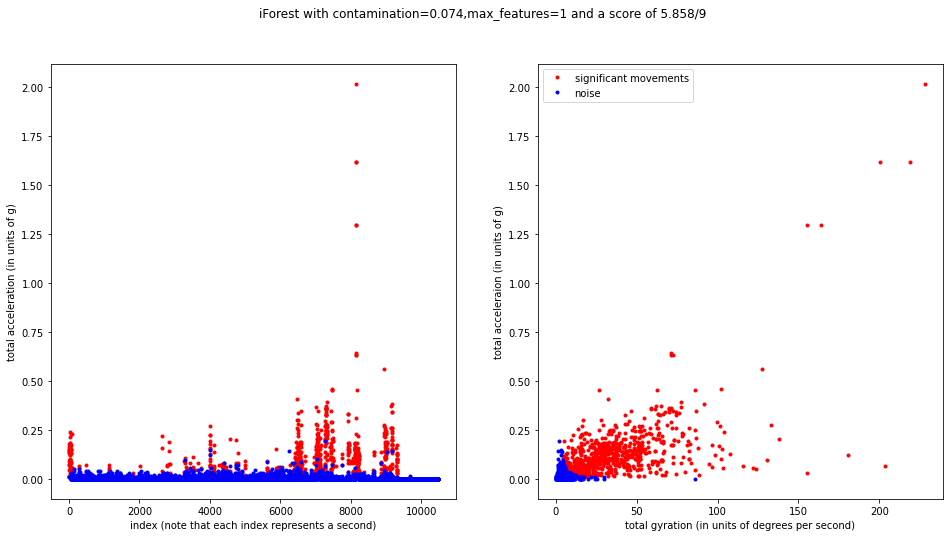

In [8]:
iForest = IsolationForest(n_estimators = 100, max_features = 1,\
                          contamination = 0.074, random_state = 0).fit(X_train)
with open ('/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Models/iForest.pkl',"wb") as f:
    pickle.dump(iForest,f)
output = iForest.predict(X_train)
true_false = []
                
for item in output:
    if item == 1:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df[true_false]
actuals = df[[not i for i in true_false]]
                
plt.figure(figsize = (16,8))
plt.suptitle('iForest with contamination={},max_features={} and a score of {}/9'.format(0.074,1,5.858))            

plt.subplot(121)
plt.plot(anomalies['index'],anomalies.accTotal,'r.')
plt.plot(actuals['index'],actuals.accTotal,'b.')
plt.xlabel('index (note that each index represents a second)')
plt.ylabel('total acceleration (in units of g)')

plt.subplot(122)
plt.plot(anomalies.gyrTotal,anomalies.accTotal,'r.')
plt.plot(actuals.gyrTotal,actuals.accTotal,'b.')
plt.xlabel('total gyration (in units of degrees per second)')
plt.ylabel('total acceleraion (in units of g)')
plt.legend(['significant movements','noise'])

plt.show()

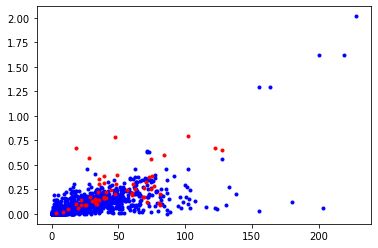

In [102]:
# plot of 'falling' to verify that data is sound

plt.plot(df.gyrTotal,df.accTotal,'b.')
plt.plot(df_test.gyrTotal[df_test.files == 2],df_test.accTotal[df_test.files == 2],'r.')
